In [1]:
#https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch
#https://bobrupakroy.medium.com/lstms-for-regression-cc9b6677697f
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pylab import mpl, plt

import torch
import torch.nn as nn
import math

torch.manual_seed(8127)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '').replace('.','-') for s in tickers]

In [3]:
#data_px = yf.download(tickers, data_source='yahoo', start = '2011-01-01', end = '2022-09-30',timeout=5)
#data_px.to_pickle('data_prices.pkl')


In [4]:
data_px=pd.read_pickle('data_prices.pkl')
data_px = data_px['Adj Close']
data_px = data_px.fillna(method='ffill')
#data_px = data_px[data_px.index>='2014-01-03']
data_px = data_px[data_px.index<'2022-10-01']
data_px = data_px[data_px.columns[(~np.isnan(data_px.iloc[0]))]]

In [5]:
#Generate price features

data_px_features = None
for asset_i in range(data_px.shape[1]):
    
    temp = data_px.iloc[:,asset_i:asset_i+1].copy()
    temp.columns=['PX']
    temp['rtn'] = ((temp.iloc[:,0]/temp.iloc[:,0].transform(lambda x: x.shift(1)))-1)
    for i in (1,5,21,21*3,252):
        temp['lag_'+str(i)] = temp.iloc[:,1].transform(lambda x: x.shift(i))
        if (i==1):
            continue
        temp['rolling_mean_'+str(i)] = temp.iloc[:,1].transform(lambda x: x.shift(28).rolling(i).mean())
        temp['rolling_std_'+str(i)]  = temp.iloc[:,1].transform(lambda x: x.shift(28).rolling(i).std())
        temp['rolling_meanpx_'+str(i)] = temp.iloc[:,0].transform(lambda x: x.shift(28).rolling(i).mean())
        
    temp = temp.iloc[np.where(~temp.isnull().any(axis=1))[0][0]:]
    
    if data_px_features is None:
        data_px_features = temp
    else:
        data_px_features = pd.concat([temp,data_px_features],axis=0,ignore_index=True)
    print(data_px_features.shape)





(2676, 19)
(5352, 19)
(8028, 19)
(10704, 19)
(13380, 19)
(16056, 19)
(18732, 19)
(21408, 19)
(24084, 19)
(26760, 19)
(29436, 19)
(32112, 19)
(34788, 19)
(37464, 19)
(40140, 19)
(42816, 19)
(45492, 19)
(48168, 19)
(50844, 19)
(53520, 19)
(56196, 19)
(58872, 19)
(61548, 19)
(64224, 19)
(66900, 19)
(69576, 19)
(72252, 19)
(74928, 19)
(77604, 19)
(80280, 19)
(82956, 19)
(85632, 19)
(88308, 19)
(90984, 19)
(93660, 19)
(96336, 19)
(99012, 19)
(101688, 19)
(104364, 19)
(107040, 19)
(109716, 19)
(112392, 19)
(115068, 19)
(117744, 19)
(120420, 19)
(123096, 19)
(125772, 19)
(128448, 19)
(131124, 19)
(133800, 19)
(136476, 19)
(139152, 19)
(141828, 19)
(144504, 19)
(147180, 19)
(149856, 19)
(152532, 19)
(155208, 19)
(157884, 19)
(160560, 19)
(163236, 19)
(165912, 19)
(168588, 19)
(171264, 19)
(173940, 19)
(176616, 19)
(179292, 19)
(181968, 19)
(184644, 19)
(187320, 19)
(189996, 19)
(192672, 19)
(195348, 19)
(198024, 19)
(200700, 19)
(203376, 19)
(206052, 19)
(208728, 19)
(211404, 19)
(214080, 19)


In [6]:
#Add in macro variables

#https://www.clevelandfed.org/indicators-and-data/inflation-nowcasting
data_macro = pd.read_csv('data_cpi_nc_all.csv')[['obs_date','CCPI_INFLATION_YoY','CPI_INFLATION_YoY']]
data_macro.columns=['Date','CCPI_INFLATION_YoY','CPI_INFLATION_YoY']

#https://en.macromicro.me/charts/3997/global-ofr-fsi
data_macro2 = pd.read_csv('data_ofr_all.csv')[['obs_date','ofr_usa','ofr_otherdm','ofr_em']]
data_macro2.columns=['Date','FSI_USA','FSI_DM','FSI,EM']

#https://en.macromicro.me/charts/22907/sp-sector-performance
data_macro3 = pd.read_csv('data_sp_all.csv')
data_macro3 = data_macro3[['obs_date']+list(data_macro3.columns[:-1][1:])]
data_macro3.columns = ['Date']+list(['SEC_'+s for s in data_macro3.columns[1:].str.upper()])

data_macro = pd.merge(data_macro,data_macro2,on="Date",how="outer")
data_macro = pd.merge(data_macro,data_macro3,on="Date",how="outer")
data_macro = data_macro[data_macro['Date']>='2014-01-03']
data_macro = data_macro.sort_values('Date')

data_macro = pd.merge(data_macro,pd.DataFrame({'Date':list(data_px.index.strftime('%Y-%m-%d'))}),on="Date",how="right")

data_macro = data_macro.fillna(method='ffill')
data_macro.index = pd.to_datetime(data_macro['Date'])
del data_macro['Date']

# Train a universal Price Trend LSTM

In [7]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    test_set_size = int(np.round(0.2*data_raw.shape[0]));
    train_set_size = data_raw.shape[0] - (test_set_size);    
    
    
    scaler  = MinMaxScaler(feature_range=(-1, 1))
    scaler  = scaler.fit(data_raw[:train_set_size])
    data_raw_scaled  = scaler.transform(data_raw)
    
    data = []
    datay = []
    total_look_back = look_back + oos_prediction_window

    # create all possible sequences of length look_back
    for index in range(len(data_raw_scaled) - total_look_back): 
        data.append(data_raw_scaled[index: index + total_look_back])

    data = np.array(data)

    x_train = data[:train_set_size,range(0,look_back),:]    
    x_test = data[train_set_size:,range(0,look_back),:]
    
    del data
    for index in range(len(data_raw_scaled) - total_look_back): 
        datay.append(data_raw[index: index + total_look_back,:1])
    
    datay = np.array(datay)
    
    y_train = datay[:train_set_size,range(look_back,total_look_back),0]
    y_test = datay[train_set_size:,range(look_back,total_look_back),0]
    
    y_train = np.apply_along_axis(lambda x:((x[-1]/x[0])-1),1,y_train)
    y_test = np.apply_along_axis(lambda x:((x[-1]/x[0])-1),1,y_test)

    
    return [x_train, y_train, x_test, y_test,scaler]

look_back = 21*3 # choose sequence length
oos_prediction_window = 21

x_train, y_train, x_test, y_test,scaler = load_data(data_px_features, look_back)




In [8]:
y_train = y_train.reshape([-1,1])
y_test = y_test.reshape([-1,1])

x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)



print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  torch.Size([961219, 63, 19])
y_train.shape =  torch.Size([961219, 1])
x_test.shape =  torch.Size([240221, 63, 19])
y_test.shape =  torch.Size([240221, 1])


In [9]:
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 512
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)



In [10]:
# Build model
#####################
input_dim = x_train.shape[2]
hidden_dim = 312
num_layers = 2 


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,dropout=0.4).to(device)

        # Readout layer
        self.fc = nn.Linear(hidden_dim,32).to(device)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1).to(device)
        

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        #print(f'h0 size = {h0.size()}')

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        #print(f'c0 size = {c0.size()}')


        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers)
model.to(device)


print(model)


LSTM(
  (lstm): LSTM(19, 312, num_layers=2, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=312, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Train model
#####################

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.RAdam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimiser, 'min',factor=0.5,patience=3,min_lr =1e-8)

num_epochs = 200
hist = np.zeros(num_epochs)
hist_val = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    model.train()
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        
        # Forward pass
        y_train_pred = model(x_batch)
        loss = loss_fn(y_train_pred, y_batch)
        del y_train_pred
        
        
        hist[t] += loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1) #Prevent exploding gradient

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
        # Every 100 batches, print the loss for this batch
        # as well as the number of examples processed so far 
        if id_batch % 100 == 0:
            loss, current =  hist[t]/(id_batch+1), (id_batch + 1)* len(x_batch)
            print(f"Epoch {t}. Cumulative Train loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")        
        
    
    
    hist[t]/=(id_batch+1)
    
    torch.cuda.empty_cache()
    
    
    #Compute validation loss
    model.eval()
    val_loss =0
    for id_batch, (x_batch, y_batch) in enumerate(dataloader_test):
        y_test_pred = model(x_batch)
        hist_val[t] += loss_fn(y_test_pred, y_batch)
        del y_test_pred
    
    hist_val[t]/=(id_batch+1)
    print("Epoch ", t, "TRAIN-MSE: ", hist[t]," VAL-MSE:",hist_val[t],"LR:",optimiser.param_groups[0]['lr'])

    # Update Scheduler
    scheduler.step(val_loss)

Epoch 0. Cumulative Train loss: 0.017376  [  512/961219]
Epoch 0. Cumulative Train loss: 0.087704  [51712/961219]
Epoch 0. Cumulative Train loss: 0.091214  [102912/961219]
Epoch 0. Cumulative Train loss: 0.064546  [154112/961219]
Epoch 0. Cumulative Train loss: 0.059369  [205312/961219]
Epoch 0. Cumulative Train loss: 0.065697  [256512/961219]
Epoch 0. Cumulative Train loss: 0.063293  [307712/961219]
Epoch 0. Cumulative Train loss: 0.055965  [358912/961219]
Epoch 0. Cumulative Train loss: 0.054512  [410112/961219]
Epoch 0. Cumulative Train loss: 0.053279  [461312/961219]
Epoch 0. Cumulative Train loss: 0.055461  [512512/961219]
Epoch 0. Cumulative Train loss: 0.051598  [563712/961219]
Epoch 0. Cumulative Train loss: 0.048258  [614912/961219]
Epoch 0. Cumulative Train loss: 0.050447  [666112/961219]
Epoch 0. Cumulative Train loss: 0.047672  [717312/961219]
Epoch 0. Cumulative Train loss: 0.047441  [768512/961219]
Epoch 0. Cumulative Train loss: 0.045265  [819712/961219]
Epoch 0. Cumulat

In [17]:
torch.save(model.state_dict(),'models/lstmv2.pth')

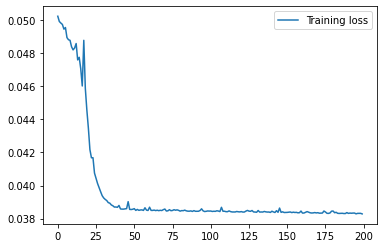

In [15]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

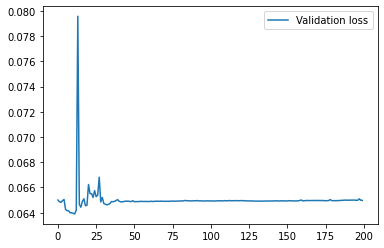

In [16]:
plt.plot(hist_val, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred_unscaled = scaler.inverse_transform(y_train_pred.to('cpu').detach().numpy())
y_train_actual_unscaled = scaler.inverse_transform(y_train.to('cpu').detach().numpy())

y_test_pred_unscaled = scaler.inverse_transform(y_test_pred.to('cpu').detach().numpy())
y_test_actual_unscaled = scaler.inverse_transform(y_test.to('cpu').detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_pred_unscaled, y_train_actual_unscaled))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_pred_unscaled, y_test_actual_unscaled))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(data_px[len(data_px)-len(y_test):].index, y_test_unscaled, color = 'red', label = 'Real IBM Stock Price')
axes.plot(data_px[len(data_px)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.plot(y_test_pred_unscaled[120],color="green",label="predicted")
axes.plot(y_test_actual_unscaled[120],color="blue",label="actual")
plt.legend()
plt.show()